In [1]:
#数据准备
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from metpy import units
from netCDF4 import Dataset
import metpy.constants as constants
import metpy.calc as mpcalc
import cartopy.io.shapereader as shpreader
from matplotlib.path import Path
from cartopy.mpl.patch import geos_to_path
from metpy.interpolate import inverse_distance_to_grid
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
from scipy import stats
import scipy.ndimage as ndimage
from mpl_toolkits.basemap import Basemap
import time
from matplotlib.dates import DateFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
import cftime
import mpath
import matplotlib.path as mpath
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import os
import glob
import dask.array as da
import cmaps
import import_ipynb
from cartopy.util import add_cyclic_point
from matplotlib import rcParams
import sys
sys.path.append(r'C:\zjh\Python\jupyterProject\jupyterProject')
import code_study as cs
from datetime import datetime as dt
from datetime import timedelta
from matplotlib.ticker import FixedLocator
import scipy
from scipy.stats import linregress
# %run code_study.ipynb

In [2]:
def TM90(lonl,lonr,data0):
    delta=np.array([-5, 0, 5])
    data=data0.sel(lon=slice(lonl,lonr))
    TM90=xr.zeros_like(data.sel(lat=60))
    G_S_all=[]
    G_N_all=[]
    for dl in delta:
        phi_n=70+dl
        phi_o=57.5+dl
        phi_s=45+dl
        G_S=(data.sel(lat=phi_o)- data.sel(lat=phi_s).values) / (phi_o - phi_s)
        G_N=(data.sel(lat=phi_n)- data.sel(lat=phi_o).values) / (phi_n - phi_o)
        G_S_all.append(G_S)
        G_N_all.append(G_N)
        condition = (G_S > 0) & (G_N < -10)
        TM90 = TM90.where(~condition, 1) #保留condition为True的值，其他位置替换为1
    return TM90,G_S_all, G_N_all
# 乌拉尔地区：30-90°E 45-70°N.

In [3]:
def data_all(lat1,lat2,lon1,lon2,year,allyear,var):
 
    path=r'D:\data\Data_concat\\'+str(year)+'_'+var+'\\'+var+'_1979_'+str(year-1)+'03.nc'
    isExists=os.path.exists(path)
    if not isExists:
        os.mkdir(path)
        files=glob.glob('E://data//ERA5.daily.1x1//'+var+'//'+var+'.*.nc')[12*(year-1979-allyear)+3:12*(year-1979)+3]
        data_scatter=[]
        lon_c=np.arange(-360,360,1)
        for file in files:  #按照顺序在 files 里面进行每一个文件的 数据名称 循环读取
            f=xr.open_dataset(file)  # 打开第一个文件
            if var=='Z':
                if f.g0_lon_3[-1]>300:
                    data_c=np.tile(f[var].loc[:,500,:,:],(1,1,2))
                    data_dac=xr.DataArray(data_c,coords=[f.initial_time0_hours,f.g0_lat_2,lon_c],dims=['time','lat','lon'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]/9.8
                else:
                    uf1c,lonc=add_cyclic_point(f[var].loc[:,500,:,:],coord=f.g0_lon_3, axis=-1)
                    data_dac=xr.DataArray(uf1c,coords=[f.initial_time0_hours,f.g0_lat_2,lonc],dims=['time','lat','lon'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]/9.8
            else:
                if f.g0_lon_2[-1]>300:
                    data_c=np.tile(f[var],(1,1,2))
                    data_dac=xr.DataArray(data_c,coords=[f.initial_time0_hours,f.g0_lat_1,lon_c],dims=['time','lat','lon'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]   
                else:
                    uf1c,lonc=add_cyclic_point(f[var],coord=f.g0_lon_2, axis=-1)
                    data_dac=xr.DataArray(uf1c,coords=[f.initial_time0_hours,f.g0_lat_1,lonc],dims=['time','lat','lon'])
                    t0=data_dac.loc[:,lat1:lat2,lon1:lon2]
            data_scatter.append(t0)
        t1=xr.concat(data_scatter,dim='time')
        mask=(t1.time.dt.month.isin([2])&t1.time.dt.day.isin([29]))
        t=t1.loc[~mask]
        if var=='Z':
            lat=t.lat.loc[lat1:lat2]
            lon=t.lon.loc[lon1:lon2]
        else:
            lat=t.lat.loc[lat1:lat2]
            lon=t.lon.loc[lon1:lon2]
        t_cli=t.values.reshape(allyear,365,len(lat),len(lon))
        time=pd.date_range('2010-04-01','2011-03-31',freq='D')
        t_cli_nc=xr.DataArray(t_cli,coords=[np.arange(1979,1979+allyear),time,lat,lon],dims=['year','time','lat','lon'],name=var+'_cli')
        t_cli_nc.to_netcdf(path+'\\'+var+'_1979_'+str(year-1)+'03.nc')
    elif var=='Z':
        t_cli_nc=xr.open_dataset(path+'\\'+var+'_1979_'+str(year-1)+'03.nc').Z_cli
    else:
        t_cli_nc=xr.open_dataset(path+'\\'+var+'_1979_'+str(year-1)+'03.nc').T2m_cli
    return t_cli_nc

In [4]:
data=data_all(0,90,-180,180,2025,46,'Z').interp(lat=np.arange(0,91,2.5),lon=np.arange(-180,181,2.5),method='linear')
data_cli=data.sel(year=slice(1979,2008))
data_cli_timean=data_cli.mean(dim='year')
data_cli_ano_all=data-data_cli_timean
data_cli_ano=data_cli_ano_all.sel(time=slice('2010-12-01','2011-02-28'))
data_cli_ano_detrend=data_cli_ano.copy()
data_cli_ano_detrend[:,:,:,:]=scipy.signal.detrend(data_cli_ano, axis=0, type='linear', bp=0, overwrite_data=False)
data_cli_ano_all_detrend=data_cli_ano_all.copy()
data_cli_ano_all_detrend[:,:,:,:]=scipy.signal.detrend(data_cli_ano_all, axis=0, type='linear', bp=0, overwrite_data=False)
TM90,G_S,G_N=TM90(30,90,data_cli_ano_detrend)
year=TM90.year

In [73]:
event=[]
for i in range(len(TM90.year)):
    yr= int(TM90.year[i].values)
    blocking_time= TM90[i].time.where(TM90[i].sum(dim='lon')>=1)
    blocking_time= pd.to_datetime(blocking_time).to_series().apply(lambda x: x.replace(year=yr if x.year==2010 else yr+1))
    blocking_lon_center=TM90[i].lon.where(TM90[i]==1).mean(dim='lon')
    event_time=[]
    center_distance=15
    for j in range(len(TM90.time)-5):
        # if np.abs(blocking_lon_center[j+1]-blocking_lon_center[j]) < 30 and np.abs(blocking_lon_center[j+2]-blocking_lon_center[j+1]) < 30 and np.abs(blocking_lon_center[j+3]-blocking_lon_center[j+2]) < 30 and np.abs(blocking_lon_center[j+4]-blocking_lon_center[j+3]) < 30 and np.abs(blocking_lon_center[j+5]-blocking_lon_center[j+4]) < 30 and blocking_time[j] not in event_time:
        if np.abs(blocking_lon_center[j+1]-blocking_lon_center[j]) < center_distance and np.abs(blocking_lon_center[j+2]-blocking_lon_center[j+1]) < center_distance and np.abs(blocking_lon_center[j+3]-blocking_lon_center[j+2]) < center_distance and np.abs(blocking_lon_center[j+4]-blocking_lon_center[j+3]) < center_distance and np.abs(blocking_lon_center[j+5]-blocking_lon_center[j+4]) < center_distance and blocking_time[j] not in event_time:
            event_individual=[]
            event_time.append(blocking_time[j])
            event_individual.append(blocking_time[j])
            for k in range(len(TM90.time)-j-1):
                k=k+j+1
                if k<5+j+1 or np.abs(blocking_lon_center[k]-blocking_lon_center[k-1]) < center_distance:
                    event_time.append(blocking_time[k])
                    event_individual.append(blocking_time[k])
                else:
                    break
            event.append(event_individual)

In [74]:
time_all=pd.date_range('1979-04-01','2025-03-31',freq='D')
time_all=time_all[~(time_all.month.isin([2])&time_all.day.isin([29]))]
time_all_summer=time_all[time_all.month.isin([12,1,2])]
Z500_ano=xr.DataArray(data_cli_ano.values.reshape(46*90,37,145),coords=[time_all_summer,data_cli_ano.lat,data_cli_ano.lon],dims=['time','lat','lon'],name='Z500_ano')
Z500_ano_all=xr.DataArray(data_cli_ano_all.values.reshape(46*365,37,145),coords=[time_all,data_cli_ano.lat,data_cli_ano.lon],dims=['time','lat','lon'],name='Z500_ano_all')
lon=np.arange(-60,120.1,2.5)
lat=data_cli_ano.lat
lat_ural=np.arange(45,70.1,2.5)
Z500_event_mean=[((Z500_ano.sel(time=ti,lat=slice(45,70),lon=slice(30,90)))*np.cos(np.radians(lat_ural[np.newaxis,:,np.newaxis]))/sum(np.cos(np.radians(lat_ural)))).sum(dim=['lat']).mean(dim=['lon']) for ti in event]
Z500_ano_mean=((Z500_ano.sel(lat=slice(45,70),lon=slice(-60,120)))*np.cos(np.radians(lat_ural[np.newaxis,:,np.newaxis]))/sum(np.cos(np.radians(lat_ural)))).sum(dim=['lat'])

In [75]:
for i in range(len(Z500_event_mean)-1,-1,-1):
    if max(Z500_event_mean[i])<0:
        Z500_event_mean.pop(i)
        event.pop(i)

In [76]:
len(event)

120

In [77]:

Z500_event_time_center=[max(Z500_event_mean[i]).time for i in range(len(Z500_event_mean))]

Z500_event_center_mean=[(Z500_ano_all.sel(time=slice((pd.to_datetime(Z500_event_time_center[i].values)-timedelta(days=11)).strftime('%Y-%m-%d'), (pd.to_datetime(Z500_event_time_center[i].values)+timedelta(days=15)).strftime('%Y-%m-%d')),lat=slice(45,70),lon=slice(-30,90))*np.cos(np.radians(lat_ural[np.newaxis,:,np.newaxis]))/sum(np.cos(np.radians(lat_ural)))).sum(dim=['lat']) for i in range(len(Z500_event_time_center))]

Z500_event_center_mean_all=[(Z500_ano_all.sel(time=slice((pd.to_datetime(Z500_event_time_center[i].values)-timedelta(days=16)).strftime('%Y-%m-%d'), (pd.to_datetime(Z500_event_time_center[i].values)+timedelta(days=20)).strftime('%Y-%m-%d')),lat=slice(45,70),lon=slice(-60,120))*np.cos(np.radians(lat_ural[np.newaxis,:,np.newaxis]))/sum(np.cos(np.radians(lat_ural)))).sum(dim=['lat']) for i in range(len(Z500_event_time_center))]

for i in range(len(Z500_event_time_center)):
    if len(Z500_event_center_mean[i].time) > 26:
        Z500_event_center_mean[i]=Z500_event_center_mean[i][1:]
    if len(Z500_event_center_mean_all[i].time) > 36:
        Z500_event_center_mean_all[i]=Z500_event_center_mean_all[i][1:]
    Z500_event_center_mean[i]['time']=np.arange(26*i,26*(i+1),1)
Z500_event_center_31=xr.concat(Z500_event_center_mean,dim='time')
Z500_event_center_31_kmeans=Z500_event_center_31.values.reshape(len(event),26,49).reshape(len(event),26*49)


# KMeans聚类分析

(120, 1274)


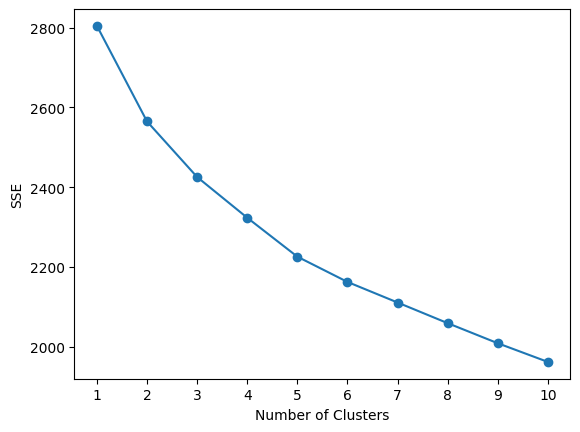

<Figure size 640x480 with 0 Axes>

In [78]:
from sklearn.cluster import KMeans
cluster_data = Z500_event_center_31_kmeans.copy()
cluster_data_normalized = (cluster_data - np.min(cluster_data))/(np.max(cluster_data) - np.min(cluster_data))
print(cluster_data_normalized.shape)
data_1 = cluster_data_normalized
sse = [] #Sum of Squared Errors
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, n_init =9, random_state = 42, init = 'k-means++')
    kmeans.fit(data_1)
    sse.append(kmeans.inertia_)
plt.plot(range(1,11), sse, marker = 'o')
plt.xticks(range(1,11))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_sse.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_sse.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_sse.eps',dpi=300,bbox_inches='tight')

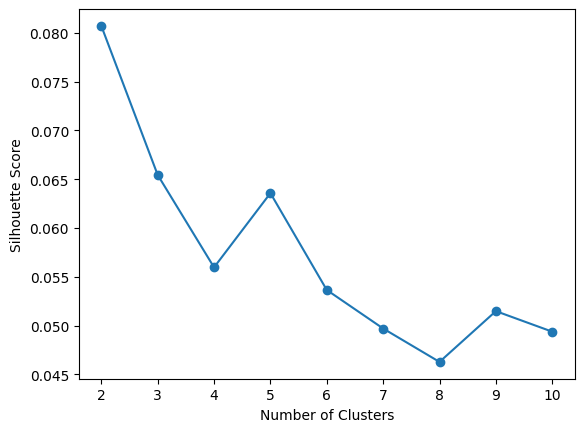

<Figure size 640x480 with 0 Axes>

In [79]:
from sklearn.metrics import silhouette_samples, silhouette_score

sihouette_score = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, n_init =9, random_state = 42, init = 'k-means++')
    kmeans.fit(data_1)
    sihouette_score.append(silhouette_score(data_1, kmeans.labels_))
plt.plot(range(2,11), sihouette_score, marker = 'o')
plt.xticks(range(2,11))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_silhouette_score.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_silhouette_score.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_silhouette_score.eps',dpi=300,bbox_inches='tight')

# 4类

In [ ]:
import openpyxl
kmeans_final = KMeans(n_clusters=4, n_init =9, random_state = 42, init = 'k-means++')
kmeans_final.fit(data_1)
print('平均轮廓系数：', silhouette_score(data_1, kmeans_final.labels_))
print('样本轮廓系数：', silhouette_samples(data_1, kmeans_final.labels_))
print('样本分类：', kmeans_final.labels_)
print('样本对应事件', np.arange(len(Z500_event_time_center))+1)
data = {
    '样本分类': kmeans_final.labels_,
    '样本对应事件':  np.arange(len(Z500_event_time_center))+1,
    '平均轮廓系数': silhouette_score(data_1, kmeans_final.labels_),  # 重复平均值以匹配行数
    '样本轮廓系数': silhouette_samples(data_1, kmeans_final.labels_)
}
df = pd.DataFrame(data)
# 保存到Excel文件
# df.to_excel('cluster_analysis_results_1.xlsx', index=False)
centers = kmeans_final.cluster_centers_
Z500_event_center_mean_all_remv=Z500_event_center_mean_all.copy()
kmeans.labels_=list(kmeans_final.labels_)
event_according=list(np.arange(len(Z500_event_time_center))+1)
for cla in np.where(silhouette_samples(data_1, kmeans.labels_)< 0.03)[0][::-1]:
    Z500_event_center_mean_all_remv.pop(cla)
    kmeans.labels_.pop(cla)
    event_according.pop(cla)
kmeans.labels_chr=[chr(ord('a')+kmeans.labels_[i]) for i in range(len(kmeans.labels_))]
event_filter=np.column_stack((event_according, kmeans.labels_chr))
kmeans.labels_=np.array(kmeans.labels_)
print(f'筛选后事件: {event_filter}')


cluster1_center ,cluster2_center,cluster3_center,cluster4_center= centers[0].reshape(26,49),centers[1].reshape(26,49),centers[2].reshape(26,49),centers[3].reshape(26,49)
cluster1_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==0)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster2_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==1)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster3_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==2)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster4_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==3)[0]],dim='time').values.reshape(-1,36,73).mean(0)

fig = plt.figure(figsize=(40,32))
plt.subplots_adjust(wspace=0.3)
rcParams["axes.linewidth"] = 2
rcParams['font.family'] = 'Arial'

rcParams['hatch.linewidth'] = 3  # 控制点的线宽
rcParams['hatch.color'] = 'black'  # 修改图案颜色
temperature_cmap = cmaps.temp_19lev
# 获取该色图的颜色
colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))

# 让中间两个颜色成为白色
midpoint = len(colors) // 2  # 找到色图的中间位置
colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色

# 创建新的色图
temperature_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)

ax = fig.add_subplot(2,2,1)
ax.set_title('A ('+str(np.where(kmeans.labels_==0)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(2,2,2)
ax.set_title('B ('+str(np.where(kmeans.labels_==1)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(2,2,3)
ax.set_title('C ('+str(np.where(kmeans.labels_==2)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

ax = fig.add_subplot(2,2,4)
ax.set_title('D ('+str(np.where(kmeans.labels_==3)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)
cb_ax = fig.add_axes([0.24, 0.02, 0.54, 0.025])  # [左, 下, 宽, 高]
cb = fig.colorbar(c1, ax=ax,cax=cb_ax,orientation='horizontal', fraction=0.05, pad=0.1) #extendrect=True
cb.ax.tick_params(labelsize=70)
cb.set_ticks(np.arange(-80,81,20))
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_cluster_4.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_cluster_4.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_cluster_4.eps',dpi=300,bbox_inches='tight')

# 3类

In [ ]:
import openpyxl
kmeans_final = KMeans(n_clusters=3, n_init =9, random_state = 42, init = 'k-means++')
kmeans_final.fit(data_1)
print('平均轮廓系数：', silhouette_score(data_1, kmeans_final.labels_))
print('样本轮廓系数：', silhouette_samples(data_1, kmeans_final.labels_))
print('样本分类：', kmeans_final.labels_)
print('样本对应事件', np.arange(len(Z500_event_time_center))+1)
data = {
    '样本分类': kmeans_final.labels_,
    '样本对应事件':  np.arange(len(Z500_event_time_center))+1,
    '平均轮廓系数': silhouette_score(data_1, kmeans_final.labels_),  # 重复平均值以匹配行数
    '样本轮廓系数': silhouette_samples(data_1, kmeans_final.labels_)
}
df = pd.DataFrame(data)
# 保存到Excel文件
# df.to_excel('cluster_analysis_results_1.xlsx', index=False)
centers = kmeans_final.cluster_centers_

Z500_event_center_mean_all_remv=Z500_event_center_mean_all.copy()
kmeans.labels_=list(kmeans_final.labels_)
event_according=list(np.arange(len(Z500_event_time_center))+1)
for cla in np.where(silhouette_samples(data_1, kmeans.labels_)< 0.05)[0][::-1]:
    Z500_event_center_mean_all_remv.pop(cla)
    kmeans.labels_.pop(cla)
    event_according.pop(cla)
kmeans.labels_chr=[chr(ord('a')+kmeans.labels_[i]) for i in range(len(kmeans.labels_))]
event_filter=np.column_stack((event_according, kmeans.labels_chr))
kmeans.labels_=np.array(kmeans.labels_)
print(f'筛选后事件: {event_filter}')

cluster1_center ,cluster2_center,cluster3_center= centers[0].reshape(26,49),centers[1].reshape(26,49),centers[2].reshape(26,49)
cluster1_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==0)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster2_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==1)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster3_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==2)[0]],dim='time').values.reshape(-1,36,73).mean(0)

fig = plt.figure(figsize=(40,32))
plt.subplots_adjust(wspace=0.3)
rcParams["axes.linewidth"] = 2
rcParams['font.family'] = 'Arial'

rcParams['hatch.linewidth'] = 3  # 控制点的线宽
rcParams['hatch.color'] = 'black'  # 修改图案颜色
temperature_cmap = cmaps.temp_19lev
# 获取该色图的颜色
colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))

# 让中间两个颜色成为白色
midpoint = len(colors) // 2  # 找到色图的中间位置
colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色

# 创建新的色图
temperature_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)

ax = fig.add_subplot(2,2,1)
ax.set_title('A ('+str(np.where(kmeans.labels_==0)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(2,2,2)
ax.set_title('B ('+str(np.where(kmeans.labels_==1)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(2,2,3)
ax.set_title('C ('+str(np.where(kmeans.labels_==2)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)
cb_ax = fig.add_axes([0.24, 0.02, 0.54, 0.025])  # [左, 下, 宽, 高]
cb = fig.colorbar(c1, ax=ax,cax=cb_ax,orientation='horizontal', fraction=0.05, pad=0.1) #extendrect=True
cb.ax.tick_params(labelsize=70)
cb.set_ticks(np.arange(-80,81,20))
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_cluster_3.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_cluster_3.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_cluster_3.eps',dpi=300,bbox_inches='tight')

# 5类

In [ ]:
import openpyxl
kmeans_final = KMeans(n_clusters=5, n_init =9, random_state = 42, init = 'k-means++')
kmeans_final.fit(data_1)
print('平均轮廓系数：', silhouette_score(data_1, kmeans_final.labels_))
print('样本轮廓系数：', silhouette_samples(data_1, kmeans_final.labels_))
print('样本分类：', kmeans_final.labels_)
print('样本对应事件', np.arange(len(Z500_event_time_center))+1)
data = {
    '样本分类': kmeans_final.labels_,
    '样本对应事件':  np.arange(len(Z500_event_time_center))+1,
    '平均轮廓系数': silhouette_score(data_1, kmeans_final.labels_),  # 重复平均值以匹配行数
    '样本轮廓系数': silhouette_samples(data_1, kmeans_final.labels_)
}
df = pd.DataFrame(data)
# 保存到Excel文件
# df.to_excel('cluster_analysis_results_1.xlsx', index=False)
centers = kmeans_final.cluster_centers_

Z500_event_center_mean_all_remv=Z500_event_center_mean_all.copy()
kmeans.labels_=list(kmeans_final.labels_)
event_according=list(np.arange(len(Z500_event_time_center))+1)
for cla in np.where(silhouette_samples(data_1, kmeans.labels_)< 0.03)[0][::-1]:
    Z500_event_center_mean_all_remv.pop(cla)
    kmeans.labels_.pop(cla)
    event_according.pop(cla)
kmeans.labels_chr=[chr(ord('a')+kmeans.labels_[i]) for i in range(len(kmeans.labels_))]
event_filter=np.column_stack((event_according, kmeans.labels_chr))
kmeans.labels_=np.array(kmeans.labels_)
print(f'筛选后事件: {event_filter}')

cluster1_center ,cluster2_center,cluster3_center,cluster4_center,cluster5_center= centers[0].reshape(26,49),centers[1].reshape(26,49),centers[2].reshape(26,49),centers[3].reshape(26,49),centers[4].reshape(26,49)
cluster1_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==0)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster2_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==1)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster3_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==2)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster4_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==3)[0]],dim='time').values.reshape(-1,36,73).mean(0)
cluster5_events = xr.concat([Z500_event_center_mean_all_remv[cla] for cla in np.where(kmeans.labels_==4)[0]],dim='time').values.reshape(-1,36,73).mean(0)


fig = plt.figure(figsize=(40,48))
plt.subplots_adjust(wspace=0.3)
rcParams["axes.linewidth"] = 2
rcParams['font.family'] = 'Arial'

rcParams['hatch.linewidth'] = 3  # 控制点的线宽
rcParams['hatch.color'] = 'black'  # 修改图案颜色
temperature_cmap = cmaps.temp_19lev
# 获取该色图的颜色
colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))

# 让中间两个颜色成为白色
midpoint = len(colors) // 2  # 找到色图的中间位置
colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色

# 创建新的色图
temperature_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)

ax = fig.add_subplot(3,2,1)
ax.set_title('A ('+str(np.where(kmeans.labels_==0)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster1_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(3,2,2)
ax.set_title('B ('+str(np.where(kmeans.labels_==1)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster2_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(3,2,3)
ax.set_title('C ('+str(np.where(kmeans.labels_==2)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster3_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

ax = fig.add_subplot(3,2,4)
ax.set_title('D ('+str(np.where(kmeans.labels_==3)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster4_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

ax = fig.add_subplot(3,2,5)
ax.set_title('E ('+str(np.where(kmeans.labels_==2)[0].shape[0])+' cases)',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,37), cluster5_events, zorder=0,levels =np.arange(-80,81,10) ,
                              cmap=temperature_cmap,extend='both')
C2 = ax.contour(lon,np.arange(1,37), cluster5_events, zorder=0,levels =np.arange(10,301,20),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,37), cluster5_events, zorder=0,levels =np.arange(-290,0,20),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,37), cluster5_events, zorder=0,levels =np.arange(10,11,20),linestyles='-',colors='black',linewidths=8)
plt.xlim((-60, 120))
plt.ylim((1, 36))
ax.set_yticks([1,6,11,16,21,26,31,36])
ax.set_yticklabels(['-15', '-10', '-5','0','5', '10', '15', '20'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

cb_ax = fig.add_axes([0.24, 0.02, 0.54, 0.025])  # [左, 下, 宽, 高]
cb = fig.colorbar(c1, ax=ax,cax=cb_ax,orientation='horizontal', fraction=0.05, pad=0.1) #extendrect=True
cb.ax.tick_params(labelsize=70)
cb.set_ticks(np.arange(-80,81,20))
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_cluster_5.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_cluster_5.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Ural_blocking_cluster_5.eps',dpi=300,bbox_inches='tight')

# 绘制1993 1994 年个例 Hovmöller diagram

In [ ]:
Z500_event_time_center_all= xr.concat(Z500_event_time_center, dim='time')
Z500_event_time_center_all.sel(time=slice('1993-12-01','1995-02-28'))

In [ ]:
fig = plt.figure(figsize=(35,20))
plt.subplots_adjust(wspace=0.3)
rcParams["axes.linewidth"] = 2
rcParams['font.family'] = 'Arial'

rcParams['hatch.linewidth'] = 3  # 控制点的线宽
rcParams['hatch.color'] = 'black'  # 修改图案颜色

lon1=np.arange(-60,121,2.5)
ax = fig.add_subplot(1,2,1)
ax.set_title('(a) 1993_1994_Z500_Ano',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon1,np.arange(1,90+1), Z500_ano_mean.sel(time=slice('1993-12-01','1994-02-28')), zorder=0,levels =np.arange(-240,241,30) ,cmap=cmap,extend='both')
C2 = ax.contour(lon1,np.arange(1,90+1), Z500_ano_mean.sel(time=slice('1993-12-01','1994-02-28')), zorder=0,levels =np.arange(60,61,60),linestyles='--',colors='red',linewidths=6)
ax.axhline(36,ls='--',c='black',linewidth=6)
ax.axhline(39,ls='--',c='black',linewidth=6)
plt.xlim((-60, 120))
plt.ylim((1, 90))
ax.set_yticks([1,11,21,32,42,52,63,73,83,90])
ax.set_yticklabels(['01Dec','11Dec', '21Dec', '01Jan', '11Jan', '21Jan', '01Feb', '11Feb', '21Feb', '28Feb'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))    
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

ax = fig.add_subplot(1,2,2)
ax.set_title('(b) 1994_1995_Z500_Ano',y=1.015,font={'family':'Arial','size':60},loc='left')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon1,np.arange(1,90+1), Z500_ano_mean.sel(time=slice('1994-12-01','1995-02-28')), zorder=0,levels =np.arange(-240,241,30) ,cmap=cmap,extend='both')
C2 = ax.contour(lon1,np.arange(1,90+1), Z500_ano_mean.sel(time=slice('1994-12-01','1995-02-28')), zorder=0,levels =np.arange(60,61,60),linestyles='--',colors='red',linewidths=6)
ax.axhline(51,ls='--',c='black',linewidth=6)
plt.xlim((-60, 120))
plt.ylim((1, 90))
ax.set_yticks([1,11,21,32,42,52,63,73,83,90])
ax.set_yticklabels(['01Dec','11Dec', '21Dec', '01Jan', '11Jan', '21Jan', '01Feb', '11Feb', '21Feb', '28Feb'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-60,121,15))
ax.set_xticklabels(['-60W', '','-30W', '', '0','','30°E', '', '60°E','', '90°E','','120°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-60,121,30)))    
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)
cb_ax = fig.add_axes([0.15, -0.04, 0.7, 0.05])  # [左, 下, 宽, 高]
cb = fig.colorbar(c1, ax=ax,cax=cb_ax,orientation='horizontal', fraction=0.05, pad=0.1) #extendrect=True
cb.ax.tick_params(labelsize=70)
cb.set_ticks(np.arange(-240,241,60))
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Event_1993_1994_5.jpg',dpi=300,bbox_inches='tight')

# 计算1979-2021年夏季daily 500hPa高度异常

In [ ]:
time_all=pd.date_range('1979-12-01','2025-03-31',freq='D')
time_all_summer=time_all[time_all.month.isin([12,1,2])]
mask=(time_all_summer.month.isin([2])&time_all_summer.day.isin([29]))
time_all_summer=time_all_summer[~mask]
Z500_ano=xr.DataArray(data_cli_ano_detrend.values.reshape(46*90,37,145),coords=[time_all_summer,data_cli_ano.lat,data_cli_ano.lon],dims=['time','lat','lon'],name='Z500_ano')
lon=np.arange(-60,150.1,2.5)
lat=data_cli_ano.lat

In [ ]:
for event_num in range(1,len(event)+1):
# for event_num in range(20):
    blocking_evnet1=Z500_ano.sel(time=event[event_num-1])
    fig = plt.figure(figsize=(34,math.ceil(len(event[event_num-1])/4)*5))
    for i in range(0,len(event[event_num-1]),1): 
        ax = fig.add_subplot(math.ceil(len(event[event_num-1])/4),4,i+1,projection = ccrs.PlateCarree())
        # ax.set_title('Z500&Z500 anom 26-30 Jan',font={'family':'Arial','size':30},loc='center')    #改改改
        ax.set_title('(' + chr(ord('a') + i) + ') +' + str(i+1) + ' day',font={'family':'Arial','size':37},loc='left')
        ax.add_feature(cfeature.COASTLINE.with_scale('50m')) 
        ax.add_feature(cfeature.LAKES, alpha=0.5)
        if i>len(event[event_num-1])-5:
            ax.set_xticks(np.array([20,60,100,140,180]), crs=ccrs.PlateCarree())
        if (i) % 4==0:
            ax.set_yticks(np.array([20,40,60,80]), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
        ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
        cs.draw_rectangle(30,90,45,70,ax)
        # black_rectangle(1,60,21,50,ax)
        import cmaps
        cmap1=cmaps.BlueWhiteOrangeRed
        cmap=cmaps.BlueYellowRed
        c1 = ax.contourf(lon,lat, blocking_evnet1[i].sel(lon=slice(-60,150)), zorder=0,levels =np.arange(-240,241,30) ,
                             transform=ccrs.PlateCarree(), cmap=cmap1,extend='both')

        ax.tick_params(axis='x', labelsize=30)
        ax.tick_params(axis='y', labelsize=30)
        ax.xaxis.set_major_locator(FixedLocator(np.arange(-50,151,50)))    
        ax.xaxis.set_minor_locator(MultipleLocator(10))  
        ax.yaxis.set_major_locator(FixedLocator(np.arange(0,90,20)))    
        ax.yaxis.set_minor_locator(MultipleLocator(10)) 
        ax.tick_params(axis="x", which="major", direction="out", width=4, length=16,labelsize=35)
        ax.tick_params(axis='x', which="minor", direction="out", width=2, length=8)
        ax.tick_params(axis="y", which="major", direction="out", width=4, length=16,labelsize=35)
        ax.tick_params(axis='y', which="minor", direction="out", width=2, length=8)
    position=fig.add_axes([0.93, 0.14,  0.015, 0.7])
    cb = plt.colorbar(c1,cax=position,fraction=0.032, pad=0.2,orientation='vertical')
    cb.ax.tick_params(labelsize=40)
    cb.set_ticks(np.arange(-240,241,60))
    cs.mkdir_directory(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_daily')
    plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_daily\Z500_25_daily_event'+str(event_num)+'.jpg',dpi=300,bbox_inches='tight')
# plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_daily\Z500_25_daily_event'+str(event_num)+'.pdf',dpi=300,bbox_inches='tight')
# plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_daily\Z500_25_daily_event'+str(event_num)+'.eps',dpi=300,bbox_inches='tight')

# 绘制所有事件平均

In [ ]:
time_all=pd.date_range('1979-12-01','2025-03-31',freq='D')
time_all_summer=time_all[time_all.month.isin([12,1,2])]
mask=(time_all_summer.month.isin([2])&time_all_summer.day.isin([29]))
time_all_summer=time_all_summer[~mask]
Z500_ano=xr.DataArray(data_cli_ano_detrend.values.reshape(46*90,37,145),coords=[time_all_summer,data_cli_ano.lat,data_cli_ano.lon],dims=['time','lat','lon'],name='Z500_ano')
Z500_ano_event=Z500_ano.loc[sum(event,[])]
Z500_ano_event_timean=Z500_ano_event.mean('time')
lon=np.arange(-60,150.1,2.5)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1,projection = ccrs.PlateCarree())
ax.set_title('DJF_detrend',y=1.015,font={'family':'Arial','size':37},loc='left')
ax.add_feature(cfeature.COASTLINE.with_scale('50m')) 
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.array([20,60,100,140,180]), crs=ccrs.PlateCarree())
ax.set_yticks(np.array([20,40,60,80]), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
cs.draw_rectangle(30,90,45,70,ax)
# black_rectangle(1,60,21,50,ax)
import cmaps
cmap1=cmaps.BlueWhiteOrangeRed
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,lat, Z500_ano_event_timean.sel(lon=slice(-60,150)), zorder=0,levels =np.arange(-80,81,10) ,
                     transform=ccrs.PlateCarree(), cmap=cmap1,extend='both')
C2 = ax.contour(lon,lat, Z500_ano_event_timean.sel(lon=slice(-60,150)), zorder=0,levels =np.arange(-160,0,10),linestyles='--',colors='black',linewidths=2)
C3 = ax.contour(lon,lat, Z500_ano_event_timean.sel(lon=slice(-60,150)), zorder=0,levels =np.arange(10,161,10),linestyles='-',colors='black',linewidths=2)

ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.xaxis.set_major_locator(FixedLocator(np.arange(-50,151,50)))    
ax.xaxis.set_minor_locator(MultipleLocator(10))  
ax.yaxis.set_major_locator(FixedLocator(np.arange(0,90,20)))    
ax.yaxis.set_minor_locator(MultipleLocator(10)) 
ax.tick_params(axis="x", which="major", direction="out", width=4, length=16,labelsize=35)
ax.tick_params(axis='x', which="minor", direction="out", width=2, length=8)
ax.tick_params(axis="y", which="major", direction="out", width=4, length=16,labelsize=35)
ax.tick_params(axis='y', which="minor", direction="out", width=2, length=8)
position=fig.add_axes([0.15, 0.14,  0.7, 0.03])
cb = plt.colorbar(c1,cax=position,fraction=0.032, pad=0.2,orientation='horizontal')
cb.ax.tick_params(labelsize=40)
cb.set_ticks(np.arange(-80,81,20))
cs.mkdir_directory(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\Z500_anomean.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\Z500_anomean.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\Z500_anomean.eps',dpi=300,bbox_inches='tight')

# EOF分解

In [ ]:
from eofs.xarray import Eof

import openpyxl
kmeans_final = KMeans(n_clusters=4, n_init =9, random_state = 42, init = 'k-means++')
kmeans_final.fit(data_1)
data = {
    '样本分类': kmeans_final.labels_,
    '样本对应事件':  np.arange(len(Z500_event_time_center))+1,
    '平均轮廓系数': silhouette_score(data_1, kmeans_final.labels_),  # 重复平均值以匹配行数
    '样本轮廓系数': silhouette_samples(data_1, kmeans_final.labels_)
}
df = pd.DataFrame(data)
# 保存到Excel文件
# df.to_excel('cluster_analysis_results_1.xlsx', index=False)
centers = kmeans_final.cluster_centers_
Z500_event_center_mean_remv=Z500_event_center_mean.copy()
kmeans.labels_=list(kmeans_final.labels_)
event_according=list(np.arange(len(Z500_event_time_center))+1)
for cla in np.where(silhouette_samples(data_1, kmeans.labels_)< 0.03)[0][::-1]:
    Z500_event_center_mean_remv.pop(cla)
    
ano=np.array(Z500_event_center_mean_remv).reshape(-1,26,49)
ano_dataarray=xr.DataArray(ano,coords=[np.arange(1,len(Z500_event_center_mean_remv)+1),np.arange(1,27),np.arange(-30,91,2.5)],dims=['time','event_day','lon'],name='Z500_ano')
# # 计算纬度权重
# lat = np.array(lat)
# coslat = np.cos(np.deg2rad(lat)) # 计算每个纬度的余弦值
# wgts = np.sqrt(coslat)[...,np.newaxis] # 使用np.sqrt(coslat)计算权重，增加纬度对计算的影响

#创建EOF分解器
## 初始化Eof类，传入异常值数据ano和计算得到的纬度权重wgts，为后续的 EOF 分析做好准备
solver = Eof(ano_dataarray) 
## 计算前4个EOF模式，并将结果标准化为相关性。neofs=4指定需要的空间模态数。
eof = solver.eofsAsCorrelation(neofs=6)
## 计算前4个时间序列主成分（PCs），npcs=4指定数量，pcscaling=1表示不对主成分进行缩放。
pc = solver.pcs(npcs=6,pcscaling=1)
## 计算前 4 个模式所解释的方差比例（解释度），neigs=4指定所需的模式数。
var = solver.varianceFraction(neigs=6)*100


In [ ]:
lon=np.arange(-30,91,2.5)
fig = plt.figure(figsize=(40,32+16))
plt.subplots_adjust(wspace=0.3)
rcParams["axes.linewidth"] = 2
rcParams['font.family'] = 'Arial'

rcParams['hatch.linewidth'] = 3  # 控制点的线宽
rcParams['hatch.color'] = 'black'  # 修改图案颜色
temperature_cmap = cmaps.temp_19lev
# 获取该色图的颜色
colors = temperature_cmap(np.linspace(0, 1, temperature_cmap.N))

# 让中间两个颜色成为白色
midpoint = len(colors) // 2  # 找到色图的中间位置
colors[midpoint-1:midpoint+1] = np.array([1, 1, 1, 1])  # 设置中间的两个颜色为白色

# 创建新的色图
temperature_cmap = mcolors.LinearSegmentedColormap.from_list("custom_temp", colors)

ax = fig.add_subplot(3,2,1)
ax.set_title('(a) EOF1',y=1.015,font={'family':'Arial','size':60},loc='left')
ax.set_title("{:.2f}".format(var[0].values)+'%',y=1.015,font={'family':'Arial','size':60},loc='right')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,27), eof[0], zorder=0,levels =np.arange(-0.8,0.81,0.1) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,27), eof[0], zorder=0,levels =np.arange(0.1,3.01,0.2),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,27), eof[0], zorder=0,levels =np.arange(-2.9,0,0.2),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,27), eof[0], zorder=0,levels =np.arange(0.1,1.1,0.2),linestyles='-',colors='black',linewidths=8)
plt.xlim((-30, 90))
plt.ylim((1, 26))
ax.set_yticks([1,6,11,16,21,26])
ax.set_yticklabels(['-10', '-5','0','5', '10', '15'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-30,91,15))
ax.set_xticklabels(['-30W', '', '0','','30°E', '', '60°E','', '90°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-30,91,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

ax = fig.add_subplot(3,2,2)
ax.set_title('(b) EOF2',y=1.015,font={'family':'Arial','size':60},loc='left')
ax.set_title("{:.2f}".format(var[1].values)+'%',y=1.015,font={'family':'Arial','size':60},loc='right')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,27), eof[1], zorder=0,levels =np.arange(-0.8,0.81,0.1) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,27), eof[1], zorder=0,levels =np.arange(0.1,3.01,0.2),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,27), eof[1], zorder=0,levels =np.arange(-2.9,0,0.2),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,27), eof[1], zorder=0,levels =np.arange(0.1,1.1,0.2),linestyles='-',colors='black',linewidths=8)
plt.xlim((-30, 90))
plt.ylim((1, 26))
ax.set_yticks([1,6,11,16,21,26])
ax.set_yticklabels(['-10', '-5','0','5', '10', '15'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-30,91,15))
ax.set_xticklabels(['-30W', '', '0','','30°E', '', '60°E','', '90°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-30,91,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)

ax = fig.add_subplot(3,2,3)
ax.set_title('(c) EOF3',y=1.015,font={'family':'Arial','size':60},loc='left')
ax.set_title("{:.2f}".format(var[2].values)+'%',y=1.015,font={'family':'Arial','size':60},loc='right')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,27), eof[2], zorder=0,levels =np.arange(-0.8,0.81,0.1) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,27), eof[2], zorder=0,levels =np.arange(0.1,3.01,0.2),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,27), eof[2], zorder=0,levels =np.arange(-2.9,0,0.2),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,27), eof[2], zorder=0,levels =np.arange(0.1,1.1,0.2),linestyles='-',colors='black',linewidths=8)
plt.xlim((-30, 90))
plt.ylim((1, 26))
ax.set_yticks([1,6,11,16,21,26])
ax.set_yticklabels(['-10', '-5','0','5', '10', '15'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-30,91,15))
ax.set_xticklabels(['-30W', '', '0','','30°E', '', '60°E','', '90°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-30,91,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(3,2,4)
ax.set_title('(d) EOF4',y=1.015,font={'family':'Arial','size':60},loc='left')
ax.set_title("{:.2f}".format(var[3].values)+'%',y=1.015,font={'family':'Arial','size':60},loc='right')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,27), eof[3], zorder=0,levels =np.arange(-0.8,0.81,0.1) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,27), eof[3], zorder=0,levels =np.arange(0.1,3.01,0.2),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,27), eof[3], zorder=0,levels =np.arange(-2.9,0,0.2),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,27), eof[3], zorder=0,levels =np.arange(0.1,1.1,0.2),linestyles='-',colors='black',linewidths=8)
plt.xlim((-30, 90))
plt.ylim((1, 26))
ax.set_yticks([1,6,11,16,21,26])
ax.set_yticklabels(['-10', '-5','0','5', '10', '15'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-30,91,15))
ax.set_xticklabels(['-30W', '', '0','','30°E', '', '60°E','', '90°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-30,91,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(3,2,5)
ax.set_title('(e) EOF5',y=1.015,font={'family':'Arial','size':60},loc='left')
ax.set_title("{:.2f}".format(var[4].values)+'%',y=1.015,font={'family':'Arial','size':60},loc='right')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,27), eof[4], zorder=0,levels =np.arange(-0.8,0.81,0.1) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,27), eof[4], zorder=0,levels =np.arange(0.1,3.01,0.2),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,27), eof[4], zorder=0,levels =np.arange(-2.9,0,0.2),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,27), eof[4], zorder=0,levels =np.arange(0.1,1.1,0.2),linestyles='-',colors='black',linewidths=8)
plt.xlim((-30, 90))
plt.ylim((1, 26))
ax.set_yticks([1,6,11,16,21,26])
ax.set_yticklabels(['-10', '-5','0','5', '10', '15'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-30,91,15))
ax.set_xticklabels(['-30W', '', '0','','30°E', '', '60°E','', '90°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-30,91,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)


ax = fig.add_subplot(3,2,6)
ax.set_title('(f) EOF6',y=1.015,font={'family':'Arial','size':60},loc='left')
ax.set_title("{:.2f}".format(var[5].values)+'%',y=1.015,font={'family':'Arial','size':60},loc='right')
cmap=cmaps.BlueYellowRed
c1 = ax.contourf(lon,np.arange(1,27), eof[5], zorder=0,levels =np.arange(-0.8,0.81,0.1) ,
                              cmap=temperature_cmap ,extend='both')
C2 = ax.contour(lon,np.arange(1,27), eof[5], zorder=0,levels =np.arange(0.1,3.01,0.2),linestyles='-',colors='black',linewidths=4)
C2 = ax.contour(lon,np.arange(1,27), eof[5], zorder=0,levels =np.arange(-2.9,0,0.2),linestyles='--',colors='black',linewidths=4)
C3 = ax.contour(lon,np.arange(1,27), eof[5], zorder=0,levels =np.arange(0.1,1.1,0.2),linestyles='-',colors='black',linewidths=8)
plt.xlim((-30, 90))
plt.ylim((1, 26))
ax.set_yticks([1,6,11,16,21,26])
ax.set_yticklabels(['-10', '-5','0','5', '10', '15'],
                       font={'family': 'Arial', 'size': 60})
ax.set_xticks(np.arange(-30,91,15))
ax.set_xticklabels(['-30W', '', '0','','30°E', '', '60°E','', '90°E'],
                       font={'family': 'Arial', 'size': 60})
# ax.set_ylabel('Date', font={'family': 'Arial', 'size': 40})
ax.xaxis.set_major_locator(FixedLocator(np.arange(-30,91,30)))       
ax.xaxis.set_minor_locator(MultipleLocator(15))  
ax.tick_params(axis="x", which="major", direction="out", width=6, length=22,labelsize=60)
ax.tick_params(axis='x', which="minor", direction="out", width=4, length=12)
ax.tick_params(axis='y',  direction="out", width=6, length=22)
cb_ax = fig.add_axes([0.24, 0.04, 0.54, 0.025])  # [左, 下, 宽, 高]
cb = fig.colorbar(c1, ax=ax,cax=cb_ax,orientation='horizontal', fraction=0.05, pad=0.1) #extendrect=True
cb.ax.tick_params(labelsize=70)
cb.set_ticks(np.arange(-0.8,0.81,0.2))
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\EOF.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\EOF.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\EOF.eps',dpi=300,bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(40,32+20))
plt.subplots_adjust(hspace=0.25)
rcParams["axes.linewidth"] = 2
rcParams['font.family'] = 'Arial'

rcParams['hatch.linewidth'] = 3  # 控制点的线宽
rcParams['hatch.color'] = 'black'  # 修改图案颜色


f1_ax2=fig.add_subplot(6,1,1)
model_pc=1-1
color1 = []
for i in range(len(Z500_event_center_mean_remv)):
    if pc[i, model_pc] >= 0:
        color1.append('red')
    elif pc[i, model_pc] < 0:
        color1.append('blue')
f1_ax2.bar(np.arange(1,len(Z500_event_center_mean_remv)+1),pc[:,model_pc],color=color1,label='PC1',width=0.8,edgecolor='black',linewidth=1.5,zorder=2)
#设置坐标轴范围
plt.xlim((0, len(Z500_event_center_mean_remv)+1))
plt.ylim((-3.5, 3.5))
f1_ax2.set_xticks(np.arange(1,len(Z500_event_center_mean_remv)+1,10))
f1_ax2.set_xticklabels(['Even1','Even11','Even21','Even31','Even41','Even51','Even61','Even71','Even81'],font={'family':'Times New Roman','size':40})
f1_ax2.set_title('(a) PC1',font={'family':'Times New Roman','size':40},loc='left')
# 设置主、副刻度线参数
#plt.tick_params(width=2,length=5,labelsize=20)
f1_ax2.tick_params(axis="both", which="major", direction="out", width=4, length=10,labelsize=40)
f1_ax2.tick_params(axis='y', which="minor", direction="out", width=2, length=5)
f1_ax2.tick_params(axis='x', which="minor", direction="out", width=2, length=5)
#设置主刻度与副刻度
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
f1_ax2.yaxis.set_major_locator(MultipleLocator(1))  #将y轴主刻度标签设置为3的倍数
f1_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  #设置y轴标签文本的格式
f1_ax2.yaxis.set_minor_locator(MultipleLocator(0.2))    #将此y轴次刻度标签设置为1的倍数
f1_ax2.xaxis.set_minor_locator(MultipleLocator(1))    #将此y轴次刻度标签设置为1的倍数

f1_ax2=fig.add_subplot(6,1,2)
model_pc=2-1
color1 = []
for i in range(len(Z500_event_center_mean_remv)):
    if pc[i, model_pc] >= 0:
        color1.append('red')
    elif pc[i, model_pc] < 0:
        color1.append('blue')
f1_ax2.bar(np.arange(1,len(Z500_event_center_mean_remv)+1),pc[:,model_pc],color=color1,label='PC1',width=0.8,edgecolor='black',linewidth=1.5,zorder=2)
#设置坐标轴范围
plt.xlim((0, len(Z500_event_center_mean_remv)+1))
plt.ylim((-3.5, 3.5))
f1_ax2.set_xticks(np.arange(1,len(Z500_event_center_mean_remv)+1,10))
f1_ax2.set_xticklabels(['Even1','Even11','Even21','Even31','Even41','Even51','Even61','Even71','Even81'],font={'family':'Times New Roman','size':40})
f1_ax2.set_title('(b) PC2',font={'family':'Times New Roman','size':40},loc='left')
# 设置主、副刻度线参数
#plt.tick_params(width=2,length=5,labelsize=20)
f1_ax2.tick_params(axis="both", which="major", direction="out", width=4, length=10,labelsize=40)
f1_ax2.tick_params(axis='y', which="minor", direction="out", width=2, length=5)
f1_ax2.tick_params(axis='x', which="minor", direction="out", width=2, length=5)
#设置主刻度与副刻度
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
f1_ax2.yaxis.set_major_locator(MultipleLocator(1))  #将y轴主刻度标签设置为3的倍数
f1_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  #设置y轴标签文本的格式
f1_ax2.yaxis.set_minor_locator(MultipleLocator(0.2))    #将此y轴次刻度标签设置为1的倍数
f1_ax2.xaxis.set_minor_locator(MultipleLocator(1))    #将此y轴次刻度标签设置为1的倍数


f1_ax2=fig.add_subplot(6,1,3)
model_pc=3-1
color1 = []
for i in range(len(Z500_event_center_mean_remv)):
    if pc[i, model_pc] >= 0:
        color1.append('red')
    elif pc[i, model_pc] < 0:
        color1.append('blue')
f1_ax2.bar(np.arange(1,len(Z500_event_center_mean_remv)+1),pc[:,model_pc],color=color1,label='PC1',width=0.8,edgecolor='black',linewidth=1.5,zorder=2)
#设置坐标轴范围
plt.xlim((0, len(Z500_event_center_mean_remv)+1))
plt.ylim((-3.5, 3.5))
f1_ax2.set_xticks(np.arange(1,len(Z500_event_center_mean_remv)+1,10))
f1_ax2.set_xticklabels(['Even1','Even11','Even21','Even31','Even41','Even51','Even61','Even71','Even81'],font={'family':'Times New Roman','size':40})
f1_ax2.set_title('(c) PC3',font={'family':'Times New Roman','size':40},loc='left')
# 设置主、副刻度线参数
#plt.tick_params(width=2,length=5,labelsize=20)
f1_ax2.tick_params(axis="both", which="major", direction="out", width=4, length=10,labelsize=40)
f1_ax2.tick_params(axis='y', which="minor", direction="out", width=2, length=5)
f1_ax2.tick_params(axis='x', which="minor", direction="out", width=2, length=5)
#设置主刻度与副刻度
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
f1_ax2.yaxis.set_major_locator(MultipleLocator(1))  #将y轴主刻度标签设置为3的倍数
f1_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  #设置y轴标签文本的格式
f1_ax2.yaxis.set_minor_locator(MultipleLocator(0.2))    #将此y轴次刻度标签设置为1的倍数
f1_ax2.xaxis.set_minor_locator(MultipleLocator(1))    #将此y轴次刻度标签设置为1的倍数


f1_ax2=fig.add_subplot(6,1,4)
model_pc=4-1
color1 = []
for i in range(len(Z500_event_center_mean_remv)):
    if pc[i, model_pc] >= 0:
        color1.append('red')
    elif pc[i, model_pc] < 0:
        color1.append('blue')
f1_ax2.bar(np.arange(1,len(Z500_event_center_mean_remv)+1),pc[:,model_pc],color=color1,label='PC1',width=0.8,edgecolor='black',linewidth=1.5,zorder=2)
#设置坐标轴范围
plt.xlim((0, len(Z500_event_center_mean_remv)+1))
plt.ylim((-3.5, 3.5))
f1_ax2.set_xticks(np.arange(1,len(Z500_event_center_mean_remv)+1,10))
f1_ax2.set_xticklabels(['Even1','Even11','Even21','Even31','Even41','Even51','Even61','Even71','Even81'],font={'family':'Times New Roman','size':40})
f1_ax2.set_title('(d) PC4',font={'family':'Times New Roman','size':40},loc='left')
# 设置主、副刻度线参数
#plt.tick_params(width=2,length=5,labelsize=20)
f1_ax2.tick_params(axis="both", which="major", direction="out", width=4, length=10,labelsize=40)
f1_ax2.tick_params(axis='y', which="minor", direction="out", width=2, length=5)
f1_ax2.tick_params(axis='x', which="minor", direction="out", width=2, length=5)
#设置主刻度与副刻度
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
f1_ax2.yaxis.set_major_locator(MultipleLocator(1))  #将y轴主刻度标签设置为3的倍数
f1_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  #设置y轴标签文本的格式
f1_ax2.yaxis.set_minor_locator(MultipleLocator(0.2))    #将此y轴次刻度标签设置为1的倍数
f1_ax2.xaxis.set_minor_locator(MultipleLocator(1))    #将此y轴次刻度标签设置为1的倍数


f1_ax2=fig.add_subplot(6,1,5)
model_pc=5-1
color1 = []
for i in range(len(Z500_event_center_mean_remv)):
    if pc[i, model_pc] >= 0:
        color1.append('red')
    elif pc[i, model_pc] < 0:
        color1.append('blue')
f1_ax2.bar(np.arange(1,len(Z500_event_center_mean_remv)+1),pc[:,model_pc],color=color1,label='PC1',width=0.8,edgecolor='black',linewidth=1.5,zorder=2)
#设置坐标轴范围
plt.xlim((0, len(Z500_event_center_mean_remv)+1))
plt.ylim((-3.5, 3.5))
f1_ax2.set_xticks(np.arange(1,len(Z500_event_center_mean_remv)+1,10))
f1_ax2.set_xticklabels(['Even1','Even11','Even21','Even31','Even41','Even51','Even61','Even71','Even81'],font={'family':'Times New Roman','size':40})
f1_ax2.set_title('(e) PC5',font={'family':'Times New Roman','size':40},loc='left')
# 设置主、副刻度线参数
#plt.tick_params(width=2,length=5,labelsize=20)
f1_ax2.tick_params(axis="both", which="major", direction="out", width=4, length=10,labelsize=40)
f1_ax2.tick_params(axis='y', which="minor", direction="out", width=2, length=5)
f1_ax2.tick_params(axis='x', which="minor", direction="out", width=2, length=5)
#设置主刻度与副刻度
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
f1_ax2.yaxis.set_major_locator(MultipleLocator(1))  #将y轴主刻度标签设置为3的倍数
f1_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  #设置y轴标签文本的格式
f1_ax2.yaxis.set_minor_locator(MultipleLocator(0.2))    #将此y轴次刻度标签设置为1的倍数
f1_ax2.xaxis.set_minor_locator(MultipleLocator(1))    #将此y轴次刻度标签设置为1的倍数


f1_ax2=fig.add_subplot(6,1,6)
model_pc=6-1
color1 = []
for i in range(len(Z500_event_center_mean_remv)):
    if pc[i, model_pc] >= 0:
        color1.append('red')
    elif pc[i, model_pc] < 0:
        color1.append('blue')
f1_ax2.bar(np.arange(1,len(Z500_event_center_mean_remv)+1),pc[:,model_pc],color=color1,label='PC1',width=0.8,edgecolor='black',linewidth=1.5,zorder=2)
#设置坐标轴范围
plt.xlim((0, len(Z500_event_center_mean_remv)+1))
plt.ylim((-3.5, 3.5))
f1_ax2.set_xticks(np.arange(1,len(Z500_event_center_mean_remv)+1,10))
f1_ax2.set_xticklabels(['Even1','Even11','Even21','Even31','Even41','Even51','Even61','Even71','Even81'],font={'family':'Times New Roman','size':40})
f1_ax2.set_title('(f) PC6',font={'family':'Times New Roman','size':40},loc='left')
# 设置主、副刻度线参数
#plt.tick_params(width=2,length=5,labelsize=20)
f1_ax2.tick_params(axis="both", which="major", direction="out", width=4, length=10,labelsize=40)
f1_ax2.tick_params(axis='y', which="minor", direction="out", width=2, length=5)
f1_ax2.tick_params(axis='x', which="minor", direction="out", width=2, length=5)
#设置主刻度与副刻度
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
f1_ax2.yaxis.set_major_locator(MultipleLocator(1))  #将y轴主刻度标签设置为3的倍数
f1_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  #设置y轴标签文本的格式
f1_ax2.yaxis.set_minor_locator(MultipleLocator(0.2))    #将此y轴次刻度标签设置为1的倍数
f1_ax2.xaxis.set_minor_locator(MultipleLocator(1))    #将此y轴次刻度标签设置为1的倍数

plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\PC.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\PC.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\PC.eps',dpi=300,bbox_inches='tight')

# 阻塞逐年演变趋势

In [185]:
event_individual_day=[]
for i in range(len(event)):
    event_individual_day.append(len(event[i]))
event_individual_day.index(max(event_individual_day))

59

In [97]:
event_sum=pd.to_datetime(sum(event,[]))
event_DJF=[]
event_days=[]
event_ano=[]
Z500_ano_lonmean=Z500_ano_mean.mean(dim='lon')
for i,year in enumerate(np.arange(1979,2024)):
    event_DJF.append(event_sum[event_sum.year.isin([year])&event_sum.month.isin([12])|event_sum.year.isin([year+1])&event_sum.month.isin([1,2])])
    event_days.append(len(event_DJF[i]))
    event_ano.append(Z500_ano_lonmean.sel(time=event_DJF[i]).mean(dim='time').values)
event_ano= np.array(event_ano)
event_ano[np.isnan(event_ano)]=np.nanmin(event_ano)
event_ano_std=cs.stand(event_ano)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


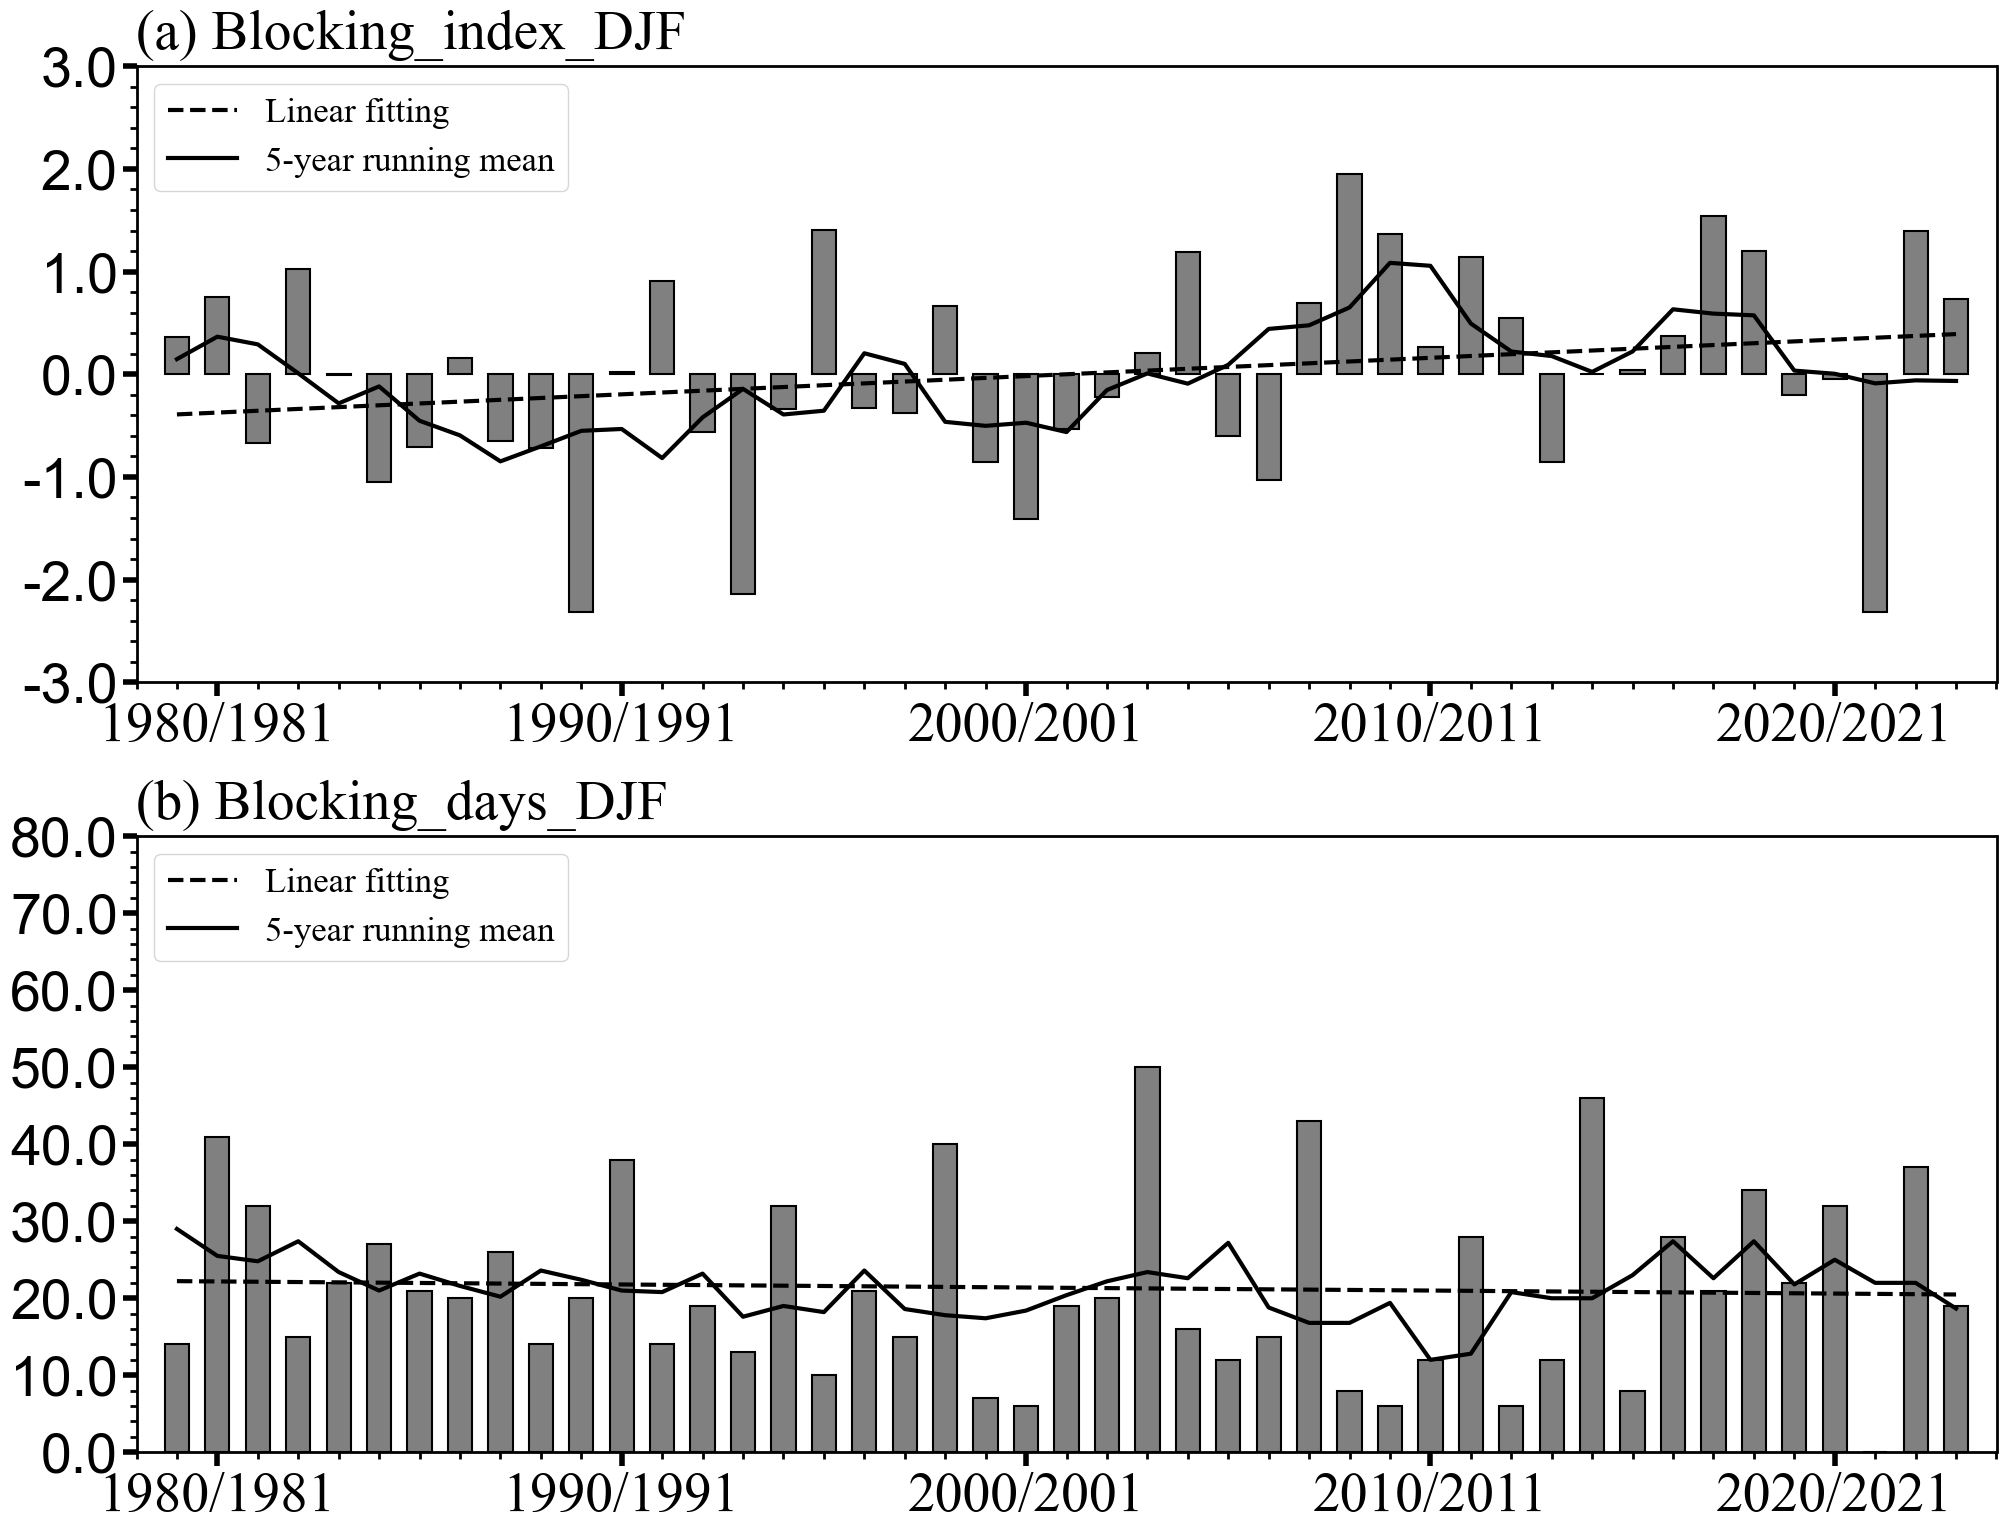

In [98]:
fig = plt.figure(figsize=(24,18))
plt.subplots_adjust(hspace=0.25)
rcParams["axes.linewidth"] = 2
rcParams['font.family'] = 'Arial'

rcParams['hatch.linewidth'] = 3  # 控制点的线宽
rcParams['hatch.color'] = 'black'  # 修改图案颜色


f1_ax2=fig.add_subplot(2,1,1)
model_pc=1-1
color1 = []
f1_ax2.bar(np.arange(1,len(event_ano_std[0])+1),event_ano_std[0],color='gray',width=0.6,edgecolor='black',linewidth=1.5,zorder=2,alpha=1)
slope, intercept, r_value, p_value, std_err = linregress(np.arange(1,len(event_ano_std[0])+1), event_ano_std[0])
f1_ax2.plot(np.arange(1,len(event_ano_std[0])+1),slope * np.arange(1,len(event_ano_std[0])+1) + intercept,color='black',label='Linear fitting',linewidth=3,linestyle='--')
f1_ax2.plot(np.arange(1,len(event_ano_std[0])+1),pd.Series(event_ano_std[0]).rolling(window=5, center=True, min_periods=1).mean(),color='black',label='5-year running mean',linewidth=3)
f1_ax2.legend(prop={'family':'Times New Roman','size':25},loc='upper left')
#设置坐标轴范围
plt.xlim((0, len(event_ano_std[0])+1))
plt.ylim((-3, 3))
f1_ax2.set_xticks(np.arange(2,len(event_ano_std[0])+1,10))
f1_ax2.set_xticklabels(['1980/1981','1990/1991','2000/2001','2010/2011','2020/2021'],font={'family':'Times New Roman','size':40})
f1_ax2.set_title('(a) Blocking_index_DJF',y=1.015,font={'family':'Times New Roman','size':40},loc='left')
# 设置主、副刻度线参数
#plt.tick_params(width=2,length=5,labelsize=20)
f1_ax2.tick_params(axis="both", which="major", direction="out", width=4, length=10,labelsize=40)
f1_ax2.tick_params(axis='y', which="minor", direction="out", width=2, length=5)
f1_ax2.tick_params(axis='x', which="minor", direction="out", width=2, length=5)
#设置主刻度与副刻度
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
f1_ax2.yaxis.set_major_locator(MultipleLocator(1))  #将y轴主刻度标签设置为3的倍数
f1_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  #设置y轴标签文本的格式
f1_ax2.yaxis.set_minor_locator(MultipleLocator(0.2))    #将此y轴次刻度标签设置为1的倍数
f1_ax2.xaxis.set_minor_locator(MultipleLocator(1))    #将此y轴次刻度标签设置为1的倍数

f1_ax2=fig.add_subplot(2,1,2)
model_pc=2-1
color1 = []
f1_ax2.bar(np.arange(1,len(event_days)+1),event_days,color='gray',width=0.6,edgecolor='black',linewidth=1.5,zorder=2,alpha=1)
slope, intercept, r_value, p_value, std_err = linregress(np.arange(1,len(event_days)+1), event_days)
f1_ax2.plot(np.arange(1,len(event_days)+1),slope * np.arange(1,len(event_days)+1) + intercept,color='black',label='Linear fitting',linewidth=3,linestyle='--')
f1_ax2.plot(np.arange(1,len(event_days)+1),pd.Series(event_days).rolling(window=5, center=True, min_periods=1).mean(),color='black',label='5-year running mean',linewidth=3)
f1_ax2.legend(prop={'family':'Times New Roman','size':25},loc='upper left')
#设置坐标轴范围
plt.xlim((0, len(event_days)+1))
plt.ylim((0, 80))
f1_ax2.set_xticks(np.arange(2,len(event_days)+1,10))
f1_ax2.set_xticklabels(['1980/1981','1990/1991','2000/2001','2010/2011','2020/2021'],font={'family':'Times New Roman','size':40})
f1_ax2.set_title('(b) Blocking_days_DJF',y=1.015,font={'family':'Times New Roman','size':40},loc='left')
# 设置主、副刻度线参数
#plt.tick_params(width=2,length=5,labelsize=20)
f1_ax2.tick_params(axis="both", which="major", direction="out", width=4, length=10,labelsize=40)
f1_ax2.tick_params(axis='y', which="minor", direction="out", width=2, length=5)
f1_ax2.tick_params(axis='x', which="minor", direction="out", width=2, length=5)
#设置主刻度与副刻度
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
f1_ax2.yaxis.set_major_locator(MultipleLocator(10))  #将y轴主刻度标签设置为3的倍数
f1_ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  #设置y轴标签文本的格式
f1_ax2.yaxis.set_minor_locator(MultipleLocator(2))    #将此y轴次刻度标签设置为1的倍数
f1_ax2.xaxis.set_minor_locator(MultipleLocator(1))    #将此y轴次刻度标签设置为1的倍数

plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\Blocking_index.jpg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\Blocking_index.pdf',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\research\dissertation\Diversity of the blocking\Test_detrend_DJF\Z500_event_all\Blocking_index.eps',dpi=300,bbox_inches='tight')